<h1 style="font-family: Arial; font-weight: 900; color: magenta; text-align: center;">UNLABELED DATA - CLUSTERING ANALYSIS</h1><br>

<br/><div style="font-family: Arial; color: darkblue; font-size: 14px; font-weight: 600"><a id="toc"></a>
In this part 10:
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[1. Grouping objects with k-means](#1)</p>
        <p style="margin: 0 0 0 4rem">[1a. k-means clustering using scikit-learn](#1a)</p>
        <p style="margin: 0 0 0 4rem">[1b. Silhouette analysis](#1b)</p><br/>
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[2. Hierarchical clustering](#2)</p>
        <p style="margin: 0 0 0 4rem">[2a. The merging algorithm](#2a)</p>
        <p style="margin: 0 0 0 4rem">[2b. Building dendrograms with scipy](#2b)</p>
        <p style="margin: 0 0 0 4rem">[2c. Attaching a heatmap to a dendrogram](#2c)</p>
        <p style="margin: 0 0 0 4rem">[2d. Agglomerative clustering with scikit-learn](#2d)</p><br/>
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[3. Density-based clustering with DBSCAN](#3)</p>
        <p style="margin: 0 0 0 4rem">[3a. The DBSCAN algorithm](#3a)</p>
        <p style="margin: 0 0 0 4rem">[3b. Running DBSCAN on an example](#3b)</p></div>

In [1]:
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy
import matplotlib.pyplot as plt

# The datasets we will use :
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons

# Beautify the code results by using colors
from colorama import Fore, Back, Style
# define some strings for cleaner codes
BB = Fore.BLUE + Style.BRIGHT
MB = Fore.MAGENTA + Style.BRIGHT

# Beautify the dataframes by using colors
def beautify(df):
    # df.style creates a Styler object from the DataFrame df, which allows styling to be applied to the
    # dataframe's representation; then 'set_table_styles' applies css styling (eg 'text-align: center')
    # to the table header cells (<th>) and data cells (<td>) of the dataframe
    # The Styler object resets the precision of floats to 6 decimal places, whatever their original format; only
    # the display is affected, though, not the original data; here, the floats are float64 numbers and correspond
    # to random numbers in [0, 10[, so there is no need to reformat them
    return df.style.set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('color', 'blue')]}, 
        {'selector': 'td', 'props': [('text-align', 'center'), ('color', 'magenta'), ('font-weight', 'bold')]}])

# Beautify figures by rendering them in SVG quality instead of JPG
# (don't use this if you prefer lightweight notebooks)
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")
# we'll use the "cyberpunk" color map
cmap = plt.get_cmap("cool")

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        In this chapter, we will explore cluster analysis, a category of unsupervised learning techniques that allows us to discover hidden structures in data whose target values or labels are not known. The goal of clustering is to find a natural grouping in data so that items in the same cluster are more similar to each other than to those from other clusters.<br>
    Examples of applications of clustering include the grouping of documents, music, and movies by different topics, or finding customers that share similar interests based on common purchase behaviors as a basis for recommendation engines.<br>$\quad$
        Given its exploratory nature, clustering is an exciting topic, and in this part, we will learn about
the following concepts :<br>
    • Find centers of similarity using the popular k-means algorithm (ch 1)<br>
    • Take a bottom-up approach to building hierarchical clustering trees ((ch 2)<br>
    • Identify arbitrary shapes of objects using a density-based clustering approach (ch 3)<br>

<a id="1"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>1. GROUPING OBJECTS WITH k-MEANS</font></h4>
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>1a. k-means clustering using scikit-learn</font><a id="1a"></a></p>$\quad$
        The <font color='darkpink'>k-means algorithm</font> belongs to the category of <font color='purple'>prototype-based clustering</font>. Each cluster is represented by a prototype, which is usually either its centroid (average) in the case of continuous features, or the medoid (the point that minimizes the distance to all other points in the cluster) in the case of categorical features.<br>$\quad$
        The k-means algorithm is extremely easy to implement (see below), and it is also computationally very efficient compared to other clustering algorithms. The main drawback of this clustering algorithm is that we need to specify the right number of clusters, <font color='darkpink'>$k$</font>. An inappropriate choice for $k$ can result in poor clustering performance.<br>
    Later in this chapter, we will discuss the <font color='purple'>elbow method</font> and <font color='purple'>silhouette plots</font>, which are useful techniques to evaluate the quality of a clustering to help us determine the optimal number of clusters, $k$.

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Although k-means clustering can be applied to data in higher dimensions, we will walk through some examples using a simple two-dimensional dataset for the purpose of visualization.<br>$\quad$
        In order to generate a set of 150 data points we use the function <font color='green'>make_blobs(n_samples=100, n_features=2, centers=None, cluster_std=1.0, shuffle=True, random_state=None, return_centers=False)</font> from the <font color='green'>datasets</font> module of <font color='green'>scikit-learn</font>; it generates clusters of points, each cluster being composed of points randomly chosen according to a gaussian distribution with mean the center of the cluster and an isotropic variance (ie a variance which is the same in all directions, which tends to favor spherical clusters); it has the following parameters :<br>
    * <font color='green'>n_samples=100</font> specifies the number of points; if it is a single integer, they will be equally distributed among clusters; we can choose the number of points per cluster by using an array instead of the integer<br>
    * <font color='green'>n_features=2</font> specifies the number of features for each point<br>
    * <font color='green'>centers=None</font> specifies the number of centers (hence the number of clusters) to generate. If <font color='green'>n_samples</font> is an int and <font color='green'>centers</font> is None (or 3), 3 centers are generated; if <font color='green'>n_samples</font> is array-like, then <font color='green'>centers</font> must be either <font color='green'>None</font> or an array of length equal to the length of <font color='green'>n_samples</font><br>
    * <font color='green'>cluster_std=1.0</font> (a float or an array of floats) specifies the standard deviation(s) of the clusters<br>
    * <font color='green'>shuffle=True</font> specifies whether or not the points should be shuffled<br>
    * <font color='green'>random_state=None</font> specifies the random number generator<br>
    * <font color='green'>return_centers=False</font> specifies whether or not the center of each cluster should be returned<br>$\quad$
        The function returns <font color='green'>X</font> - the array of shape (n_samples, n_features) of the generated data points -, <font color='green'>y</font> - the 1d-array of shape (n_samples,) of integers labeling the clusters, and, if <font color='green'>return_centers=True</font>, <font color='green'>centers</font> - the array of shape (n_centers, n_features) with the centers of the clusters.

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Let's create this dataset of 150 randomly generated points that are roughly grouped into three regions with higher density.

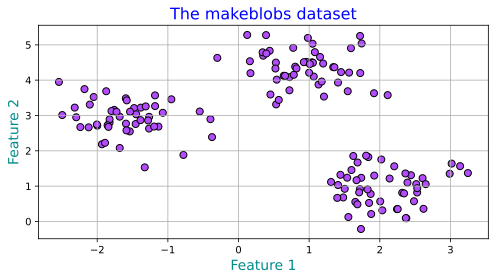

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5, shuffle=True, random_state=0)

plt.figure(figsize=(7, 4))
plt.title("The makeblobs dataset", fontsize=16, color='blue')
plt.scatter(X[:, 0], X[:, 1], marker='o', edgecolor='black', s=50, color=cmap(0.7))
plt.xlabel('Feature 1', fontsize=14, color='darkcyan')
plt.ylabel('Feature 2', fontsize=14, color='darkcyan')
plt.grid()
plt.tight_layout()
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The k-means algorithm consists of the 4 steps :<br>
    1. <font color='purple'>Randomly pick $k$ centroids</font> $\;\mu^{(j)},\, j=1,\cdots,k\;$ from the example points; they will be our initial cluster centers<br>
    2. <font color='purple'>Assign each example to the nearest centroid</font>, "nearest" according to the Euclidean distance<br>
    3. <font color='purple'>Move the centroids to the center of the example points that were assigned to it</font><br>
    4. <font color='purple'>Repeat steps 2 and 3 until the cluster assignments do not change</font> or a user-defined tolerance or maximum number of iterations is reached

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The goal of the k-means algorithm is to find the centroids $\;\mu^{(j)},\, j=1,\cdots,k\;$ which minimize the <font color='darkpink'>sum of squared errors</font> (<font color='darkpink'>$SSE$</font>), which is sometimes also called <font color='darkpink'>cluster inertia</font> :<br><p style="margin: 0 0 .5rem 0"></p><font color = darkpink>
        $$SSE \;=\; \sum_{i=1}^n \, \sum_{j=1}^k \, 1_{x^{(i)} \in C_j} \, \|x^{(i)}-\mu^{(j)}\|_2^2 \qquad (1)$$</font><br>
    where the $\;x^{(i)}, \, i=1,\cdots,n\;$ are the example points, $\, 1_{x^{(i)} \in C_j} \,$ is equal to $1$ if $\, x^{(i)} \,$ is in the group of points associated with $\mu_j\,$ and $0$ otherwise, and $\,\|.\|_2\,$ is the Euclidean norm.

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The k-means algorithm is implemented in the <font color='green'>cluster</font> module of <font color='green'>scikit-learn</font>. We use the class <font color='green'>KMeans(n_clusters=8, init='k-means++', n_init='auto', max_iter=300, tol=0.0001, verbose=0, random_state=None)</font>, where :<br>
    * <font color='green'>n_clusters=8</font> specifies the number of clusters to form as well as the number of centroids to generate<br>
    * <font color='green'>init='k-means++'</font> specifies the method for initialization : <font color='green'>random</font> means choosing <font color='green'>n_clusters</font> data points at random for the initial centroids, while <font color='green'>k-means++</font> will use the "greedy k-means++" algorithm to select the initial centroids<br>
    * <font color='green'>n_init='auto'</font> specifies the number of times the k-means algorithm is run with different centroid seeds. The final result is the best output (in terms of inertia) after <font color='green'>n_init</font> consecutive runs. Several runs are recommended for sparse high-dimensional problems. When <font color='green'>n_init='auto'</font>, the number of runs depends on the value of init: 10 if using <font color='green'>init='random'</font> (or init is a callable); 1 if using <font color='green'>init='k-means++'</font> (or init is an array-like)<br>
    * <font color='green'>max_iter=300</font> specifies the maximum number of iterations of the k-means algorithm for a single run<br>
    * <font color='green'>tol=0.0001</font> specifies the relative tolerance : convergence wil be declared if the Frobenius norm of the difference in the cluster centers of two consecutive iterations is less than <font color='green'>tol</font> (the <font color='purple'>Frobenius norm</font> of a matrix A being the square root of the sum of the squares of all the elements of A : <font color='purple'>$\|A\|_F^2 = \sum_{i=1}^{n} \sum_{j=1}^{m} A_{ij}^2$</font>)<br>
    * <font color='green'>verbose=0</font> specifies the verbosity mode<br>
    * <font color='green'>random_state=None</font> specifies the random number generator<br><br>$\quad$
        The <font color='green'>KMeans</font> class has the following attributes (among others) :<br>
    * <font color='green'>cluster_centers_</font> is the array of shape (n_clusters, n_features) containing the coordinates of the clusters' centers<br>
    * <font color='green'>inertia_</font> is the $SSE$ or inertia<br>
    * <font color='green'>n_iter_</font> is the number of iterations run

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Let's try the <font color='green'>KMeans</font> class on our example points from cell 2; first with <font color='green'>init='random'</font>, then with <font color='green'>init='k-means++'</font>. The second option is "strongly recommended in practice" and will be used in the remaining of this section :

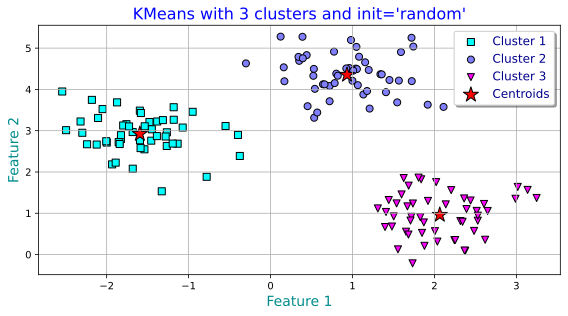

In [3]:
# I got a warning from the joblib library, which is used internally by scikit-learn for parallel processing. It
# says that the loky backend (used by joblib for parallel processing) is having trouble detecting the number of
# physical CPU cores on my potato laptop; it found 0 physical cores, which is not expected, and therefore it 
# defaults to using the logical core count. To silence this warning I followed ChatGPT's advice; my laptop has 4
# physical cores, so I need to add the following two lines. ChatGPT recommends to write them before importing
# libraries, in its own cell, but this was no better; if I run this cell twice, then the second time the warning
# does not appear
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

from sklearn.cluster import KMeans
# Fitting the KMeans algorithm
# "n_init='auto'" is equivalent here to "n_init=10" because init is 'random'
km = KMeans(n_clusters=3, init='random', n_init='auto', max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(X)

# Plotting the clusters
plt.figure(figsize=(8, 4.5))
plt.title("KMeans with 3 clusters and init='random'", fontsize=16, color='blue')
plt.scatter(X[y_km == 0, 0], X[y_km == 0, 1], s=50, marker='s', edgecolor='black', color=cmap(0),
            label='Cluster 1')
plt.scatter(X[y_km == 1, 0], X[y_km == 1, 1], s=50, marker='o', edgecolor='black', color=cmap(0.5),
            label='Cluster 2')
plt.scatter(X[y_km == 2, 0], X[y_km == 2, 1], s=50, marker='v', edgecolor='black', color=cmap(0.999),
            label='Cluster 3')
# Plotting the centroids
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=250, marker='*', c='red', edgecolor='black',
            label='Centroids')
# Adding labels and legend
plt.xlabel('Feature 1', fontsize=14, color='darkcyan')
plt.ylabel('Feature 2', fontsize=14, color='darkcyan')
plt.legend(loc='upper right', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.grid()
plt.tight_layout()
plt.show()

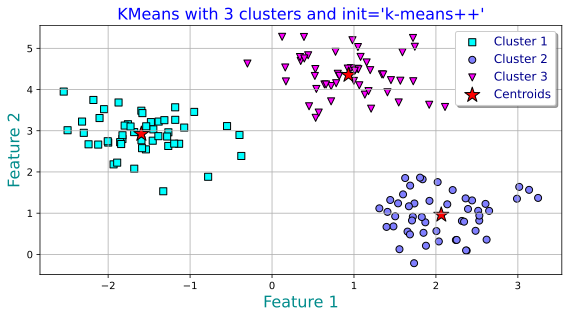

In [4]:
# Fitting the KMeans algorithm
# "n_init='auto'" is equivalent here to "n_init=1" because init is 'k-means++'
km = KMeans(n_clusters=3, init='k-means++', n_init='auto', max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(X)

# Plotting the clusters
plt.figure(figsize=(8, 4.5))
plt.title("KMeans with 3 clusters and init='k-means++'", fontsize=16, color='blue')
plt.scatter(X[y_km == 0, 0], X[y_km == 0, 1], s=50, marker='s', edgecolor='black', color=cmap(0),
            label='Cluster 1')
plt.scatter(X[y_km == 1, 0], X[y_km == 1, 1], s=50, marker='o', edgecolor='black', color=cmap(0.5),
            label='Cluster 2')
plt.scatter(X[y_km == 2, 0], X[y_km == 2, 1], s=50, marker='v', edgecolor='black', color=cmap(0.999),
            label='Cluster 3')
# Plotting the centroids
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=250, marker='*', c='red',
            edgecolor='black', label='Centroids')
# Adding labels and legend
plt.xlabel('Feature 1', fontsize=16, color='darkcyan')
plt.ylabel('Feature 2', fontsize=16, color='darkcyan')
plt.legend(loc='upper right', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.grid()    # displays the grid for better readability
plt.tight_layout()
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Although the k-means algorithm worked well on this toy dataset, in general we have the drawback of having to specify the number of clusters, $k$, a priori. This number is rarely obvious in real-world applications, especially if we are working with a higher-dimensional dataset that cannot be visualized.<br>$\quad$
        Note that if $k$ increases, the $SSE$ decreases, because the examples will be closer to the centroids they are assigned to. In order to use the smallest suitable number for k we can use the <font color='green'>inertia_</font> attribute of the <font color='green'>KMeans</font> class in order to represent the speed with which the value of $SSE$ decreases when $k$ increases and identify the value of $k$ where the distortion begins to increase most rapidly. This is called the <font color='darkpink'>elbow method</font>.<br>
    Let's apply it on our example; we can clearly see that the best value for $k$ will be $3$ :

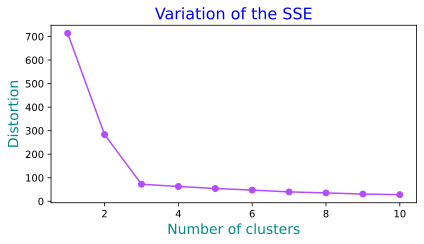

In [5]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)

plt.figure(figsize=(6, 3.5))
plt.title("Variation of the SSE", fontsize=16, color='blue')
plt.plot(range(1,11), distortions, marker='o', color=cmap(0.7))
plt.xlabel('Number of clusters', fontsize=14, color='darkcyan')
plt.ylabel('Distortion', fontsize=14, color='darkcyan')
plt.tight_layout()
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        If we use only $2$ clusters then we get a clustering which is not as good, with one of the centroids falling between two of the three spherical groupings of the input data. Although the clustering does not look completely terrible, it is suboptimal :

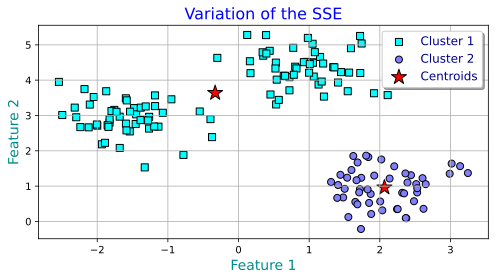

In [6]:
km = KMeans(n_clusters=2, init='k-means++', n_init='auto', max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(X)

plt.figure(figsize=(7, 4))
plt.title("Variation of the SSE", fontsize=16, color='blue')
plt.scatter(X[y_km == 0, 0], X[y_km == 0, 1], s=50, marker='s', edgecolor='black', color=cmap(0),
            label='Cluster 1')
plt.scatter(X[y_km == 1, 0], X[y_km == 1, 1], s=50, marker='o', edgecolor='black', color=cmap(0.5),
            label='Cluster 2')
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=250, marker='*', c='red',
            edgecolor='black', label='Centroids')
plt.xlabel('Feature 1', fontsize=14, color='darkcyan')
plt.ylabel('Feature 2', fontsize=14, color='darkcyan')
plt.legend(loc='upper right', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.grid()
plt.tight_layout()
plt.show()

<br><br><div style="font-family: Arial; font-size:14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>1b. Silhouette analysis</font><a id="1b"></a></p>$\quad$
        Besides $SSE$, another metric to evaluate the quality of a clustering is <font color='darkpink'>silhouette analysis</font>, which can also be applied to clustering algorithms other than k-means, as we will see later in this part 10.<br>$\quad$
        Silhouette analysis can be used as a graphical tool to plot a measure of how tightly grouped the examples
in the clusters are. To calculate the <font color='darkpink'>silhouette coefficient</font> $s^{(i)}$ of a single example $x^{(i)}$ in our dataset, we first define its <font color='darkpink'>cluster cohesion</font> $a^{(i)}$, as the average distance between $x^{(i)}$ and all other points in the same cluster; and its <font color='darkpink'>cluster separation</font> $b^{(i)}$, as the average distance between $x^{(i)}$ and all examples in the nearest cluster. Then $s^{(i)}$ is defined by<br><p style="margin: 0 0 .5rem 0"></p><font color = darkpink>
        $$s^{(i)} \;=\; \frac{b^{(i)} - a^{(i)}}{\text{max}(b^{(i)}, a^{(i)})} \;\in \big[-1\,;\,+1\big] \qquad (2)$$</font><br>$\quad$
        The more dissimilar from the examples of the closest cluster $x^{(i)}$ will be, the larger $b^{(i)}$ will be; the closer it will be from the examples of its own cluster, the smaller $a^{(i)}$ will be. In total, it is ideal if $\,b^{(i)} \gg a^{(i)}\,$ - meaning that $x^{(i)}$ is well separated from other clusters -, in which case its silhouette coefficient will be close to $1$.<br>
    On the contrary, a silhouette coefficient close to $0$ indicates overlapping clusters - because the average distance inside the cluster containing $x^{(i)}$ is approximately equal to the average distance between $x^{(i)}$ and the nearest cluster -.

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        It is possible to compute the silhouette coefficients using the <font color='green'>silhouette_samples(X, labels, metric='euclidean')</font> function from the <font color='green'>metrics</font> module of <font color='green'>scikit-learn</font>, where :<br>
    * <font color='green'>X</font> is the array of shape (n_samples, n_features) containing the data points<br>
    * <font color='green'>labels</font> is the 1d-array of shape (n_samples,) containing their labels<br>
    * <font color='green'>metric='euclidean'</font> specifies the metric to use to compute the distances<br>$\quad$
        <font color='green'>silhouette_samples</font> returns the 1d-array of shape (n_samples,) whose $k$-th component is the silhouette coefficient of the $k$-th data point in $X$ (ie the $k$-th row of $X$).<br>$\quad$
        Using <font color='green'>silhouette_samples</font>, let's create a plot of the silhouette coefficients for our example of a k-means clustering with $k = 3$; and then compare it with the silhouette plot that we would have obtained if we had used only $2$ clusters :

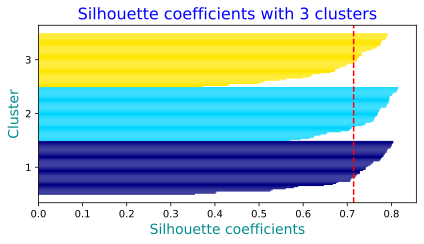

In [7]:
# we use the KMeans class from scikit-learn (presented in "1a. k-means clustering using scikit-learn") in order
# to separate X into 3 clusters
km = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
# y_km is a 1d-array where each element is the integer representing the cluster label assigned to the
# corresponding data point in X
y_km = km.fit_predict(X)

# cm is a colormap handling module that we'll use for coloring the clusters
from matplotlib import cm
from sklearn.metrics import silhouette_samples
# the np.unique function returns the various values present in an array, ordered (in an ascending order) and
# unique (only one 'a' even if there are several in the original array)
cluster_labels = np.unique(y_km)
# thus 'n_clusters' will be the number of clusters
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')

plt.figure(figsize=(6, 3.5))
plt.title("Silhouette coefficients with 3 clusters", fontsize=16, color='blue')
# initializes the lower and upper bounds for the y-axis
y_ax_lower, y_ax_upper = 0, 0
# initializes a list to store the y-ticks positions
yticks = []
# 'i' will be the index and 'c' will be the integer (representing a cluster) at index 'i'
for i, c in enumerate(cluster_labels):
    # 'c_silhouette_vals' is the set of silhouette coefficients for the data points in the cluster 'c' 
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    # updates the upper y-axis bound to accommodate the cluster 'c'
    y_ax_upper += len(c_silhouette_vals)
    # chooses a color for the current cluster using the jet colormap
    color = cm.jet(float(i) / n_clusters)
    # plots the silhouette coefficients for the cluster 'c' as horizontal bars
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none',
             color=color)
    # appends the middle position of the current cluster's bar to the y-ticks list
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    # updates the lower y-axis bound for the next cluster
    y_ax_lower += len(c_silhouette_vals)

# computes the average silhouette score across all samples
silhouette_avg = np.mean(silhouette_vals)
# draws a vertical dashed red line at the average silhouette score
plt.axvline(silhouette_avg, color="red", linestyle="--")
# places the y-ticks; 'cluster_labels + 1' is used to label clusters starting from 1 instead of 0
plt.yticks(yticks, cluster_labels + 1)
plt.xlabel('Silhouette coefficients', fontsize=14, color='darkcyan')
plt.ylabel('Cluster', fontsize=14, color='darkcyan')
plt.tight_layout()
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        With this plot we can easily see the values of the silhouette coefficients : they are the lengths of the "rectangular" shapes. The three clusters have approximately the same shapes and sizes, their data points have silhouette coefficients relatively high, with an average a little above $0.7$. These are indicators of a good clustering.<br>$\quad$
        In order to compare with a relatively bad clustering, let's do the same using only $2$ clusters. We continue the example we presented in "1a. k-means clustering using scikit-learn", cell 6. The silhouettes now have visibly different lengths and widths, which is evidence of a relatively bad or at least suboptimal clustering :

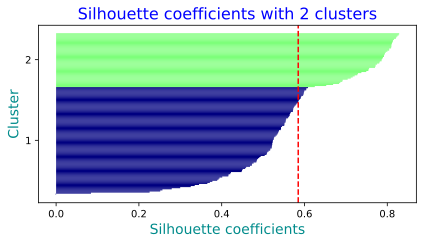

In [8]:
km = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')

plt.figure(figsize=(6, 3.5))
plt.title("Silhouette coefficients with 2 clusters", fontsize=16, color='blue')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.xlabel('Silhouette coefficients', fontsize=14, color='darkcyan')
plt.ylabel('Cluster', fontsize=14, color='darkcyan')
plt.tight_layout()
plt.show()

<a id="2"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>2. HIERARCHICAL CLUSTERING</font></h4>
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>2a. The merging algorithm</font><a id="2a"></a></p>$\quad$
        The two main approaches to <font color='darkpink'>hierarchical clustering</font> are agglomerative and divisive hierarchical clustering. In <font color='darkpink'>divisive hierarchical clustering</font>, we start with one cluster that encompasses the entire dataset, and we iteratively split the cluster into smaller clusters until each cluster contains only one example. In this chapter, we will focus on <font color='darkpink'>agglomerative clustering</font>, which takes the opposite approach. We start with each example as an individual cluster; then at each step we merge the two closest clusters (in a sense defined below) until all data points are in a single cluster.<br>$\quad$
        Thus hierarchical clustering algorithms do not require us to specify the number of clusters, contrary to k-means algorithms. Additionally, we can follow the building of the clusters using dendrograms (see the next subchapter), which can help with the interpretation of the results by creating meaningful taxonomies.

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        In the presentation above "closest" should be defined. The two standard criterions for agglomerative hierarchical clustering are <font color='purple'>single linkage</font> and <font color='purple'>complete linkage</font>.<br>
    <font color='darkpink'>Single linkage</font> defines the distance between two clusters A and B as<br><p style="margin: 0 0 .5rem 0"></p><font color = darkpink>
        $$d_s(A,B) \;=\; \min_{\substack{a \in A,\, b \in B}}\; d(a,b) \qquad (3)$$</font>
    where $d(a,b)$ is the distance, usually the Euclidean distance, between the data points $a$ and $b$.<br>
    While <font color='darkpink'>complete linkage</font> defines the distance between two clusters A and B as<br><p style="margin: 0 0 .5rem 0"></p><font color = darkpink>
        $$d_c(A,B) \;=\; \max_{\substack{a \in A,\, b \in B}}\; d(a,b) \qquad (4)$$

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Let's see this on a simple example. Suppose we have $5$ data points on a line : $A(0)$, $B(1)$, $C(2)$, $D(10)$ and $E(11)$.<br>$\quad$
        With <font color='purple'>single linkage</font> :<br>
    * step 1 : the pairs of clusters A and B, B and C, and D and E have the same distances separating them (1); in such a case the merge contains the first data point in the initial list of data points; so we get the clusters {A,B}, C, D and E<br>
    * step 2 : the pairs of clusters {A,B} and C, and D and E have the same distances separating them (1); in such a case the merge contains the first data point in the initial list of data points, even if it is already inside a cluster; so we get the clusters {A,B,C}, D and E<br>
    * step 3 : the two clusters that have the minimum distance are D and E (1), the distance between {A, B, C} and D being 8 and the distance between {A, B, C} and E being 9; so we get the clusters {A,B,C} and {D,E}<br>
    * step 4 : only two clusters remain, only one merge is possible; so we get the cluster {A,B,C,D,E}<br>$\quad$
        With <font color='purple'>complete linkage</font> :<br>
    * step 1 : the pairs of clusters A and B, B and C, and D and E have the same distances separating them (1); so we get the clusters {A,B}, C, D and E<br>
    * step 2 : here the clusters {A,B} and C are separated by a distance of $2$ (since $d(A,C)=2$), while the distance between D and E is only 1; so we get the clusters {A,B}, C and {D,E}<br>
    * step 3 : the two closest clusters are {A,B} and C; so we get the clusters {A,B,C} and {D,E}<br>
    * step 4 : only two clusters remain, only one merge is possible; so we get the cluster {A,B,C,D,E}<br>$\quad$
        Both methods yield the same results, except at step $2$. We can see that simple linkage tends to create elongated clusters because it uses the minimum distance between points. This can lead to the <font color='darkpink'>chaining effect</font> where clusters are formed by connecting close points one by one, potentially resulting in long, stringy clusters. On the contrary, complete linkage, by using the maximum distance between points, leads to more compact clusters, building well-separated clusters, but they are more sensitive to outliers.

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        There are two other common linkage methods : <font color='purple'>average linkage</font> and <font color='purple'>Ward's linkage</font>.<br>$\quad$
        <font color='darkpink'>Average linkage</font> balances the effects of single and complete linkage, leading to moderate cluster shapes, by defining the distance between two clusters A and B as the average distance between all pairs of data points in the two clusters :<br><p style="margin: 0 0 .5rem 0"></p><font color = darkpink>
        $$d_a(A,B) \;=\; \frac{1}{|A|} \frac{1}{|B|} \sum_{a \in A} \sum_{b \in B} d(a,b) \qquad (5)$$</font>
    where $|A|$ and $|B|$ are the cardinalities of $A$ and $B$ respectively.<br>$\quad$
        In <font color='darkpink'>Ward's linkage</font>, the two clusters that lead to the minimum increase of the total within-cluster $SSE$ are merged (for the definition of $SSE$, see "1a. k-means clustering using scikit-learn", equation $(1)$), which tends to produce clusters that are generally spherical and of similar size.

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>2b. Building dendrograms with scipy</font><a id="2b"></a></p>$\quad$
        The sample provided in the book is a bit too small for us to differentiate the effects of some parameters in the <font color='green'>dendrogram<font color='darkblue'> function from <font color='green'>scipy<font color='darkblue'>. Therefore, we will generate a random data sample with 10 instances instead of 5. The rows represent different observations (IDs 0-9), and the columns represent various arbitrary features (X, Y, Z) of those examples :

In [9]:
# Generate random data
n_ex = 10
np.random.seed(123)
variables = ['X', 'Y', 'Z']
# the names of the data points will be ID_0 through ID_(n_ex-1)
labels = [f'ID_{i}' for i in range(n_ex)]
# generates a NumPy array of shape (n_ex,3) of random numbers in [0,10[
X = np.random.random_sample([n_ex, 3]) * 10
# creates a Pandas dataframe 'df' using the generated random data 'X'. The 'columns' parameter assigns
# the column names ('X', 'Y', 'Z'), and the index parameter assigns the row labels
# ('ID_0' to 'ID_(n_ex-1)')
df = pd.DataFrame(X, columns=variables, index=labels)

# Apply our 'beautify' function (from cell 1) to render the dataframe
beautify(df.head())

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The first step towards building a dendrogram with Scipy is to get the <font color='darkpink'>linkage matrix</font>. This matrix provides a detailed description of the cluster merging process. It has a shape of $(n-1, 4)$ where $n$ is the number of data points (<font color='violet'>n_ex</font> in our code); each row in the linkage matrix represents a single step in the hierarchical clustering process and contains four values : the index of the first cluster merged at this step, the index of the second cluster merged at this step, the distance (according to the specified metric) between both clusters, and the total number of data points contained in the merged cluster.<br>
    Note that there are exactly $n-1$ rows : at the start all data points are individual clusters; there are $n$ of them; at each step two clusters are merged so the total number of clusters is reduced by $1$; and the process stops when there remains only $1$ cluster.

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        We can get the linkage matrix of unlabeled data points using the <font color='green'>cluster.hierarchy</font> module of <font color='green'>scipy</font> since it is the return value of the function <font color='green'>linkage(y, method='single', metric='euclidean', optimal_ordering=False)</font>, where :<br>
    * <font color='green'>y</font> is either the 2d (Numpy) array of the data points as rows and feature values as columns, or the 1d (Numpy) array of the coefficients of the upper triangular matrix of the distances between the data points (excluding the diagonal)<br>
    * <font color='green'>method='single'</font> specifies the method to use to merge the clusters. It can be 'single' (the default) for single linkage, 'complete' for complete linkage, 'average' for average linkage, 'ward' for Ward's linkage, among others<br>
    * <font color='green'>metric='euclidean'</font> specifies the distance metric to use when the first argument <font color='green'>y</font> is an array of data points, and should be ignored otherwise. There are many possible distance metrics but 'euclidean' is by far the most common<br>
    * <font color='green'>optimal_ordering=False</font> specifies if we want to reorder the data points so that the distance between successive data points is minimal, leading to an associated dendrogram easier to read or not; by default this reordering is avoided because the corresponding algorithm can be slow, particularly on large datasets

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        A <font color='darkpink'>dendrogram</font> is a tree-like diagram used to illustrate the arrangement of clusters produced by hierarchical clustering. It consists of branches that join clusters together. Each branch represents a cluster, and the height of the branches represents the distance (for a distance linkage) or dissimilarity (eg for the Ward's linkage) between the clusters, a taller height indicating that they are more distant or dissimilar. The leaves of the dendrogram represent the individual data points. As we move up the tree, branches merge to form larger clusters.<br>$\quad$
        When there are many observations, displaying the whole dendrogram is no more possible, and we can only display the last merges. This possibility exists in <font color='green'>scipy</font>. The vertical ticks remain unchanged though, the height of the merges still represent the distances (or dissimilarity) between the clusters; but in <font color='green'>scipy</font> the branches still start at $0$, which obviously does not mean that the distances within the merged clusters are $0$; if needed, we can get the true within clusters distances by using the linkage matrix.

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        We can get the dendrogram of unlabeled data points using the <font color='green'>cluster.hierarchy</font> module of <font color='green'>scipy</font> by first building the associated linkage matrix, and then using it as the main argument of the <font color='green'>dendrogram(Z, p=30, truncate_mode=None, orientation='top', labels=None, no_labels=False, show_leaf_counts=True, count_sort=False, distance_sort=False, leaf_rotation=None, leaf_font_size=None)</font> function, where I have only kept the following parameters :<br>
    * <font color='green'>Z</font> is the linkage matrix<br>
    * <font color='green'>p</font> is the parameter for 'truncate_mode'<br>
    * <font color='green'>truncate_mode=None</font> is used to cut the dendrogram and only show its top-most part. It has 3 possible values : <font color='green'>None</font> (the default) displays the whole dendrogram; <font color='green'>lastp</font> displays the cluster merging process once there remain only <font color='green'>p</font> clusters (or, equivalently, the last <font color='green'>p</font>$\,$-1 merges); and <font color='green'>level</font> displays the last <font color='green'>p</font> levels (see below)<br>
    * <font color='green'>orientation='top'</font> specifies the direction to use to plot the dendrogram by indicating the place of the dendrogram's root. It has 4 possible values : <font color='green'>'top'</font> (the default), <font color='green'>'bottom'</font>, <font color='green'>'left'</font>, and <font color='green'>'right'</font><br>
    * <font color='green'>labels=None</font> specifies the names to give to the data points; <font color='green'>None</font> means that their names will be their indices in the original list of data points; otherwise it should be a 1d-array of strings of size the number $n$ of examples. If we want no labels at all, we use the <font color='green'>no_labels</font> parameter<br>
    * <font color='green'>no_labels=False</font> specifies whether or not the function should remove the data points' labels<br>
    * <font color='green'>show_leaf_counts=True</font> specifies whether or not the merged clusters have a name; by default, they have one and it is the number of data points they contain, including those that have already been merged into clusters, between parentheses<br>
    * <font color='green'>count_sort=False</font> specifies the order in which the clusters should be plotted. It has 3 possible values : <font color='green'>False</font> (the default) leaves the clusters in their original order; <font color='green'>True</font> or <font color='green'>'ascending'</font> means that the child with the minimum number of original objects in its cluster is plotted first; and <font color='green'>'descending'</font> means that the child with the maximum number of original objects in its cluster is plotted first<br>
    * <font color='green'>distance_sort=False</font> specifies the order in which the clusters should be plotted. It has 3 possible values : <font color='green'>False</font> (the default) leaves the clusters in their original order; <font color='green'>True</font> or <font color='green'>'ascending'</font> means that the child with the minimum distance between its direct descendents is plotted first; and <font color='green'>'descending'</font> means that the child with the maximum distance between its direct descendents is plotted first<br>
    * <font color='green'>leaf_rotation=None</font> specifies the angle (in degrees) to rotate the leaf labels; it can be any double; the default corresponds to a rotation of $0°$<br>
    * <font color='green'>leaf_font_size=None</font> specifies the font size (in points) of the leaf labels. When unspecified, the size is based on the number of nodes in the dendrogram.<br><br>$\quad$
        The <font color='green'>dendrogram</font> function returns a dictionary with these key:value pairs :<br>
    * <font color='green'>'leaves'</font> : the list that specifies the order of the leaves from left to right in the dendrogram<br>
    * <font color='green'>'ivl'</font> : the list of labels corresponding to the leaves<br>
    * <font color='green'>'icoord'</font> and <font color='green'>'dcoord'</font> : if the dendrogram starts when it remains only $p$ clusters ($2 \leq p \leq n$), then <font color='green'>'icoord'</font> and <font color='green'>'dcoord'</font> are of the form <font color='green'>icoord</font> = $[I_1, \cdots, I_p]$ and <font color='green'>dcoord</font> = $[D_1, \cdots, D_p]$ where any $I_k$ is of the form $I_k = [xk_1, xk_2, xk_3, xk_4]$ and any $D_k$ is of the form $D_k = [yk_1, yk_2, yk_3, yk_4]$; the $k$-th link starts at $(xk_1, yk_1)$ then goes up to $(xk_2, yk_2)$ (it is a vertical line segment so $xk_2=xk_1$), then goes right to $(xk_3, yk_3)$ (with $yk_3=yk_2$), then goes down to $(xk_4, yk_4)$ (with $xk_4=xk_3$)<br>
    * <font color='green'>'color_list'</font> : the list of color names whose $k$-th element represents the color of the $k$-th link<br>
    * <font color='green'>'leaves_color_list'</font> : the list of color names whose $k$-th element represents the color of the $k$-th leaf

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        This will all be clearer after a few examples. Let's now continue with our data sample and show a full dendrogram and two truncated ones :

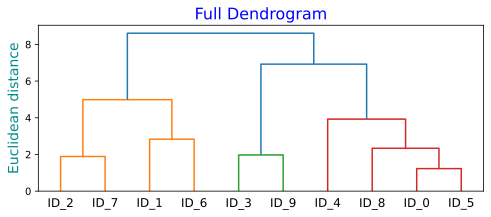

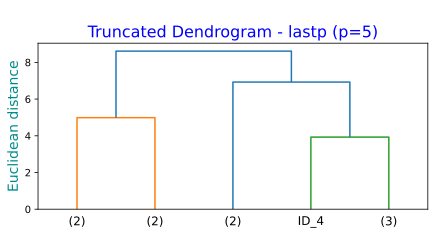

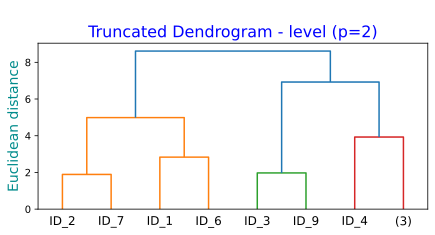

In [10]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Perform hierarchical clustering
row_clusters = linkage(df.values, method='complete', metric='euclidean')

# Plot full dendrogram
plt.figure(figsize=(8,3))
plt.title("Full Dendrogram", fontsize=16, color='blue')
plt.ylabel("Euclidean distance", fontsize=14, color='darkcyan')
dendrogram(row_clusters, labels=labels)
plt.show()

# Plot truncated dendrogram using 'lastp' with p=5
plt.figure(figsize=(7,3))
plt.title("\nTruncated Dendrogram - lastp (p=5)", fontsize=16, color='blue')
plt.ylabel("Euclidean distance", fontsize=14, color='darkcyan')
dendrogram(row_clusters, labels=labels, truncate_mode='lastp', p=5)
plt.show()

# Plot truncated dendrogram using 'level' with p=2
plt.figure(figsize=(7,3))
plt.title("\nTruncated Dendrogram - level (p=2)", fontsize=16, color='blue')
plt.ylabel('Euclidean distance', fontsize=14, color='darkcyan')
dendrogram(row_clusters, labels=labels, truncate_mode='level', p=2)
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        According to the heights of their branches, we can see that the two closest data points are ID_0 and ID_5, then ID_2 and ID_7, then ID_3 and ID_9,... and that the distance within the cluster {ID_0, ID_5, ID_8} is less than the distance between ID_1 and ID_6.

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>2c. Attaching a heatmap to a dendrogram</font><a id="2c"></a></p>$\quad$
        In practical applications, hierarchical clustering dendrograms are often used in combination with a heatmap of the matrix containing the data points, where each cell's color intensity reflects the magnitude of the corresponding data value (darker cells representing larger values).<br>$\quad$
        In order to link both the dendrogram and the data matrix, we reorder the rows of the matrix to coincide with the rearrangement done by the cluster merging process. Also we choose the same height for both diagrams; since the representations provided by <font color='green'>scipy</font> have these heights equally divided between the rows (for the leaves in the dendrogram as well as for the examples in the data matrix), these rows will coincide in height; and appear one in front of the other since we draw both diagrams side by side :

In [11]:
# creates a new figure object, 'fig', with a size of 8x8 inches. The figure will be the container for
# all the plots (axes) we add to it
fig = plt.figure(figsize=(8, 8))

# Adds a subplot for the dendrogram (I have changed the location parameters to avoid overlapping of the
# subplots and to get a clearer dendrogram)
# adds a new set of axes to the figure 'fig' and assigns it to the variable 'axd'. The 'add_axes'
# method takes a list of four values [left, bottom, width, height] that define the position and size of
# a new subplot in the figure. These values are fractions of the figure's width and height; thus
# 'left=0.2' means the left edge of the subplot is 20% of the 'fig' width from the left edge of 'fig',
# 'bottom=0.1' means the bottom edge of the subplot is 10% of the 'fig' height from the bottom edge of
# 'fig', 'width=0.3' means the subplot's width is 30% of the 'fig' width, and height=0.6 means the
# subplot's height is 60% of the 'fig' height
# at least, this is the theory; in a Jupyter notebook, although 'left=0.2', the subplot will start at
# 'left=0'... In order to get margins and center the figure, I save it and use html/css. The saved
# figure has no margins either, and using 'axd = fig.add_axes([0.2, 0.1, 0.3, 0.6])' together with
# 'axm = fig.add_axes([0.45, 0.1, 0.4, 0.6])' saves the same figure as using
# 'axd = fig.add_axes([0., 0.1, 0.3, 0.6])' together with 'axd = fig.add_axes([0.25, 0.1, 0.3, 0.6])'...
# sorry about this. I have asked ChatGPT and Deepseek R1, and they don't know either...
axd = fig.add_axes([0.2, 0.1, 0.3, 0.6])
#  this 'dendrogram' call generates a dendrogram for our data points using the linkage matrix
# 'row_clusters' (from cell 10), oriented with the root at the left so it is horizontal with the data
# points on the right. Moreover its return value, a dictionary that we will use below, is saved under
# the name 'row_dendr' (see "2b. Building dendrograms with scipy" for its precise content)
row_dendr = dendrogram(row_clusters, orientation='left')
# 'row_dendr['leaves']' is the order of the data points in the dendrogram; '[::-1]' reverses this order
# because the rotation of the dendrogram makes the last data points appear on top, while the heatmap
# will preserve the disposition of the matrix rows (with the first rows on top) and we want the data
# points in both diagrams to coincide horizontally; then 'df.iloc' reorders the rows of the original
# dataframe 'df' following this order; the result is assigned to 'df_rowclust'
df_rowclust = df.iloc[row_dendr['leaves'][::-1]]

# Customize the appearance of the dendrogram
# removes the x-ticks (ie the Euclidean distances)
axd.set_xticks([])
# removes the y-ticks (ie the data points' names); we will use those provided by the heatmap instead
axd.set_yticks([])
# removes the border lines around the dendrogram plot
for spine in axd.spines.values():
    spine.set_visible(False)

# Adds a subplot for the heatmap
# the heatmap is contiguous to the dendrogram so the rows' names can be easily associated with the
# dendrogram's leaves' names; both subplots start at the same height (0.1) and have identical heights
# (0.6), ensuring horizontal alignments of their rows
axm = fig.add_axes([0.45, 0.1, 0.4, 0.6])
# displays the heatmap using 'matshow', which visualizes 'df_rowclust' as a matrix of colors.
# 'interpolation='nearest'' ensures sharp boundaries between cells,
# 'cmap='hot_r'' sets the color map to a reversed 'hot' palette for better contrast.
# 'cax' is the matplotlib object associated with the heatmap
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap=cmap)
# adds a colorbar to the heatmap to indicate the mapping of colors to values
fig.colorbar(cax)

# Customize the appearance of the heatmap
# in Pandas, the label of a row (resp. column) is called an 'index' (resp. a 'column'). For example
# 'df_rowclust.index' (resp. 'df_rowclust.columns') is the list of the rows' (resp. columns') labels in
# the dataframe 'df.rowclust'. Here we want to display them with the heatmap.
# First, we need to set the ticks; this is done by generating a sequence of integers starting from 0 up
# to len(df_rowclust.columns)-1 for the x-ticks and then applying the 'set_xticks' function :
axm.set_xticks(range(len(df_rowclust.columns)))
# there are len(df_rowclust.index) vertical ticks :
axm.set_yticks(range(len(df_rowclust.index)))
# and now we can assign these ticks their corresponding labels :
axm.set_xticklabels(df_rowclust.columns)
axm.set_yticklabels(df_rowclust.index)

# this is done to center the figure. You can run 'plt.show()' instead if you don't want to save the figure
plt.savefig('figure.png', bbox_inches='tight')  # Save the figure with all margins
from IPython.display import display, HTML
# Close the figure to prevent it from being displayed twice
plt.close(fig)
# Display the image with HTML/CSS for centering and resizing
display(HTML(f"""
    <div style="display: flex; justify-content: center;">
        <img src="{'figure.png'}" style="width: 45%; height: 45%"></div>"""))

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>2d. Agglomerative clustering with scikit-learn</font><a id="2d"></a></p>$\quad$
        In "2b. Building dendrograms with scipy" we have used <font color='green'>scipy<font color='darkblue'> to perform a detailed cluster merging process, starting with every data point as a simple cluster and merging at each step the two closest (or more similar) clusters, up to the point where only one cluster remains, containing all the data points; then we have represented this process with a tree-like diagram called a dendrogram.<br>$\quad$
        The number of clusters decreases from $n$, the total number of data points, to $1$. If we only want to know what the clusters are when $l$ of them remain ($2 \leq l \leq n$), we can also use the class <font color='green'>AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')<font color='darkblue'> from the <font color='green'>cluster<font color='darkblue'> module of <font color='green'>scikit-learn<font color='darkblue'>, where the parameters I have selected here (there are many others) are :<br>
    * <font color='green'>n_clusters=2<font color='darkblue'> specifies this number $l$ of remaining clusters<br>
    * <font color='green'>metric='euclidean'<font color='darkblue'> specifies the metric to use to perform the mergings. The default is <font color='green'>'euclidean'<font color='darkblue'>; other possibilities are <font color='green'>'l1'<font color='darkblue'>, <font color='green'>'l2'<font color='darkblue'> (an equivalent for <font color='green'>'euclidean'<font color='darkblue'>) or <font color='green'>'cosine'<font color='darkblue'> (where the similarity between two clusters is computed from the "<font color='purple'>cosine distance<font color='darkblue'>"; the cosine distance between two vectors $u$ and $v$ is defined as $\; 1-\frac{u.v}{\Vert u \Vert \, \Vert v \Vert}$). If we want to use the Ward's linkage (see "2a. The merging algorithm") then 'metric' should be <font color='green'>'euclidean'<font color='darkblue'>.<br>
    * <font color='green'>linkage='ward'<font color='darkblue'> specifies the criterion to use to perform the mergings. The default is <font color='green'>'ward'<font color='darkblue'>; other possibilities are <font color='green'>'single'<font color='darkblue'>, <font color='green'>'complete'<font color='darkblue'> or <font color='green'>'average'<font color='darkblue'><br>$\quad$
        Among many attributes, the one which interests us here is <font color='green'>labels_<font color='darkblue'>, which is the 1d-array of length $n$ indicating to which cluster each data point belongs.

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        For example, if we want to group our data points in three clusters using the complete linkage criterion (see "2a. The merging algorithm") with the Euclidean metric, we can do :

In [12]:
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='complete')
labels = ac.fit_predict(X)
print(BB + "With only 3 clusters, the sequence of cluster labels is :" + MB, labels)

With only 3 clusters, the sequence of cluster labels is : [1 0 0 2 1 1 0 0 1 2]


<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    which is consistent with our results when using <font color='green'>scipy</font> (see "2b. Building dendrograms with scipy")<br>$\quad$
        Using this method step by step we can get the clusters and the merges at each step.

<a id="3"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>3. DENSITY-BASED CLUSTERING WITH DBSCAN</font></h4>
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>3a. The DBSCAN algorithm</font><a id="3a"></a></p>$\quad$
        As its name implies, density-based clustering assigns cluster labels based on dense regions of points. In <font color='darkpink'>DBSCAN</font> (Density-Based Spatial Clustering of Applications with Noise), the notion of density is defined as the number of points within a specified radius, $\epsilon$, and a special name is assigned to each example (data point) using the following criteria :<br>
    • A point is considered a <font color='darkpink'>core point</font> if at least a specified number (<font color='purple'>MinPts</font>) of neighboring points
fall within the specified distance $\epsilon$ (from it)<br>
    • A <font color='darkpink'>border point</font> is a point that has fewer neighbors than MinPts within the distance $\epsilon$, but lies within the ball of radius $\epsilon$ of a core point<br>
    • All other points are considered <font color='darkpink'>noise points</font>

<figure style="text-align: center;">
    <img src="10.1. Core, border and noise points for DBSCAN.png" alt="Figure showing core, border and noise points. To be a core point a point needs to have MinPts=3 neighbours within a radius of epsilon. There are three core points; they are surrounded with circles of radiuses epsilon; these circles are drawn with dashed lines. The points that are inside a circle but have less than MinPts neighbours within a distance epsilon are the border points. The points that are not inside a circle (ie that are not in the vicinity of a core point) are the noise points." width="350" />
    <figcaption style="margin-top: .5rem; font-weight: bold; color: purple">Core, border and noise points</figcaption>
</figure>

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        After labeling the points as core, border, or noise, the DBSCAN algorithm consists of two simple steps :<br><font color='purple'>
1. Create a separate cluster for each core point or group of connected core points; core points are connected iff they are no farther away than $\epsilon$<br>
2. Assign each border point to the cluster of its nearest core point</font>$\quad$
        As a result, DBSCAN naturally excludes noise points from the cluster formation process.

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>3b. Running DBSCAN on an example</font><a id="3b"></a></p>$\quad$
        Let’s create a new dataset of half-moon-shaped structures to demonstrate a situation where DBSCAN performs better than k-means clustering and hierarchical clustering, which we studied in our first two chapters. We will use the <font color='green'>make_moons(n_samples=100, shuffle=True, noise=None, random_state=None)</font>, from the <font color='green'>datasets</font> module of <font color='green'>scikit-learn</font>, where :<br>
    * <font color='green'>shuffle=True</font> specifies whether to shuffle the samples<br>
    * <font color='green'>noise=None</font> specifies the standard deviation of Gaussian noise added to the data; typically a float between $0.1$ and $0.3$

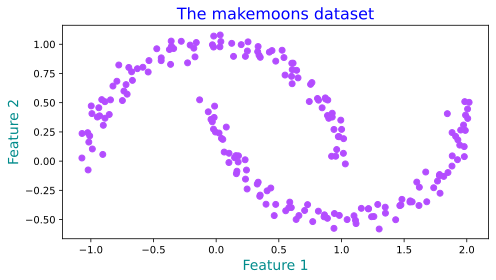

In [13]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

plt.figure(figsize=(7, 4))
plt.title("The makemoons dataset", fontsize=16, color='blue')
plt.scatter(X[:, 0], X[:, 1], color=cmap(0.7))
plt.xlabel("Feature 1", fontsize=14, color='darkcyan')
plt.ylabel("Feature 2", fontsize=14, color='darkcyan')
plt.tight_layout()
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        We will start by using the k-means algorithm and complete linkage clustering to see if one of those previously discussed clustering algorithms can successfully identify the half-moon shapes as separate clusters. The code is as follows :

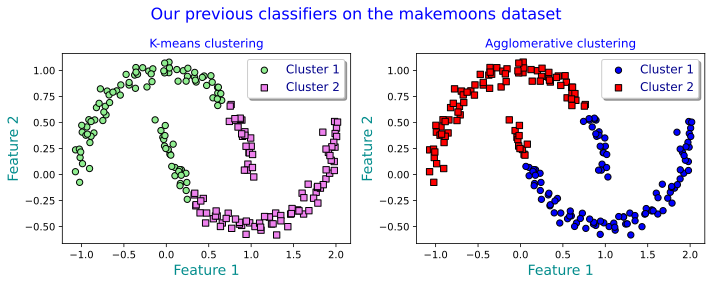

In [14]:
km = KMeans(n_clusters=2, random_state=0)
y_km = km.fit_predict(X)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle("Our previous classifiers on the makemoons dataset", fontsize=16, color='blue')
ax1.scatter(X[y_km == 0, 0], X[y_km == 0, 1], edgecolor='black', marker='o', s=40, color='lightgreen',
            label="Cluster 1")
ax1.scatter(X[y_km == 1, 0], X[y_km == 1, 1], edgecolor='black', marker='s', s=40, color='violet',
            label="Cluster 2")
ax1.set_title("K-means clustering", color='blue')
ax1.set_xlabel("Feature 1", fontsize=14, color='darkcyan')
ax1.set_ylabel("Feature 2", fontsize=14, color='darkcyan')
ax1.legend(loc='upper right', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')

ac = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='complete')
y_ac = ac.fit_predict(X)
ax2.scatter(X[y_ac == 0, 0], X[y_ac == 0, 1], edgecolor='black', marker='o', s=40, color='blue',
            label="Cluster 1")
ax2.scatter(X[y_ac == 1, 0], X[y_ac == 1, 1], edgecolor='black', marker='s', s=40, color='red',
            label="Cluster 2")
ax2.set_title("Agglomerative clustering", color='blue')
ax2.set_xlabel("Feature 1", fontsize=14, color='darkcyan')
ax2.set_ylabel("Feature 2", fontsize=14, color='darkcyan')
ax2.legend(loc='upper right', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')

plt.tight_layout()
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Both the k-means algorithm and the hierarchical clustering fail to separate the two clusters, although with complete linkage the agglomerative clustering performs slightly better.<br>$\quad$
        Now, let's try the DBSCAN algorithm using the <font color='green'>DBSCAN(eps=0.5, min_samples=5, metric='euclidean', p=None, metric_params=None, n_jobs=None)</font> class from the <font color='green'>cluster</font> module of <font color='green'>scikit-learn</font>, where :<br>
    * <font color='green'>eps=0.5</font> specifies the value of $\epsilon$, the maximum distance between two examples for one to be considered as in the neighborhood of the other<br>
    * <font color='green'>min_samples=5</font> specifies the value of MinPts+1, the minimum number of points in its neighbourhood (including itself) that a point needs to be considered as a core point<br>
    * <font color='green'>metric='euclidean'</font> specifies the metric to use when calculating distances. The default is 'euclidean' (or 'l2'); some other possibilities are <font color='green'>'l1'</font>, <font color='green'>'minkowski'</font> (which gives access to any $L^p$-norm; the value of p should be specified using the following parameter), <font color='green'>'chebyshev'</font> (the <font color='purple'>Chebyshev distance</font> is the maximum absolute difference along any coordinate dimension), or <font color='green'>'cosine'</font> (see "2d. Agglomerative clustering with scikit-learn")<br>
    * <font color='green'>p=None</font> specifies the value of p if the <font color='green'>'minkowski'</font> metric is used<br>
    * <font color='green'>metric_params=None</font> allows to specify additional parameters for the definition of the metric<br>
    * <font color='green'>n_jobs=None</font> specifies the number of parallel jobs to run. <font color='green'>None</font> means 1; -1 means using all processors<br>$\quad$
        After fitting the model, its attributes are :<br>
    * <font color='green'>core_sample_indices_</font> is the 1d-array containing the indices of the core points (with length the number 'n_core_samples' of core points)<br>
    * <font color='green'>components_</font> is the array of shape (n_core_samples, n_features) containing the core points; it is a subset of the data matrix<br>
    * <font color='green'>labels_</font> is the 1d-array of length the number $n$ of examples; its $k$-th component is the label of the cluster that the $k$-th example belongs to; the noise points have label $-1$

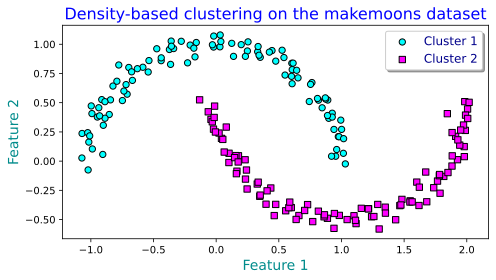

In [15]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')
y_db = db.fit_predict(X)

plt.figure(figsize=(7, 4))
plt.title("Density-based clustering on the makemoons dataset", fontsize=16, color='blue')
plt.scatter(X[y_db == 0, 0], X[y_db == 0, 1], edgecolor='black', marker='o', s=40, color=cmap(0),
            label="Cluster 1")
plt.scatter(X[y_db == 1, 0], X[y_db == 1, 1], edgecolor='black', marker='s', s=40, color=cmap(0.999),
            label="Cluster 2")
plt.xlabel("Feature 1", fontsize=14, color='darkcyan')
plt.ylabel("Feature 2", fontsize=14, color='darkcyan')
plt.legend(loc='upper right', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.tight_layout()
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The DBSCAN algorithm can successfully detect the half-moon shapes, which highlights one of the strengths of DBSCAN : clustering data of arbitrary shapes; whereas k-means and agglomerative clustering tend to find spherical or convex-shaped clusters.<br>
    Also, as we have already mentioned, DBSCAN can automatically identify and ignore outliers (noise points) as it does not assign them to any cluster.<br>
    Compared with k-means algorithm, DBSCAN has the additional advantage of not needing the number of clusters to be specified.<br>
    Compared with agglomerative clustering, DBSCAN is efficient since it does not need to compute pairwise distances of all the points : it can build the clusters one data point after another.<br>$\quad$
        However, we should also note some of the disadvantages of DBSCAN. Its main drawback is that it is highly sensitive to the choice of <font color='green'>eps</font> (the radius) and <font color='green'>min_samples</font> (the minimum number of points in a neighborhood to be a core point). Poor choices can result in either over-segmentation or under-segmentation. In particular DBSCAN may struggle with clusters of varying densities, as it uses a single <font color='green'>eps</font> value that may not be appropriate for all clusters.<br>
    Compared with k-means algorithm, DBSCAN is computationally less efficient, especially with large datasets and high-dimensional data.<br>
    Compared with agglomerative clustering, DBSCAN does not produce a hierarchy of clusters, which can be insightful for understanding data at different granularity levels.<br>$\quad$
        All these algorithms suffer from the curse of dimensionality (see part 5, "Dimensionality reduction", "1a. Presentation. The curse of dimensionality"), especially if we use the Euclidean distance. This problem is usually mitigated by using dimensionality reduction techniques, most notably principal component analysis (see part 5, "1. Principal component analysis") and t-SNE (see part 5, "3. Nonlinear dimensionality reduction"). For example, it is particularly common to compress datasets down to two-dimensional subspaces, in order to visualize the clusters, ie the groups of similar points and their assigned labels. By visualizing the clusters, we can assess whether the clustering algorithm has grouped the data meaningfully and identify potential issues.